# Setup

In [7]:
import os
import subprocess

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path

env = os.environ.copy()

env['HADOOP_CONF_DIR'] = '/home/hadoop/hadoop/etc/hadoop'
env['HIVE_HOME'] = '/home/hadoop/hive'
env['PIG_HOME'] = '/home/hadoop/pig'
env['PATH'] = f"{env['HIVE_HOME']}/bin:{env['PIG_HOME']}/bin:{env['PATH']}"

def run_hive(sql):
    subprocess.run(['hive', '-e', sql], env=env, check=True)

def run_pig(script_path):
    subprocess.run(['pig', '-x', 'mapreduce', script_path], env=env, check=True)

# Lab Hive vs Pig - Question 1 (Visualization)

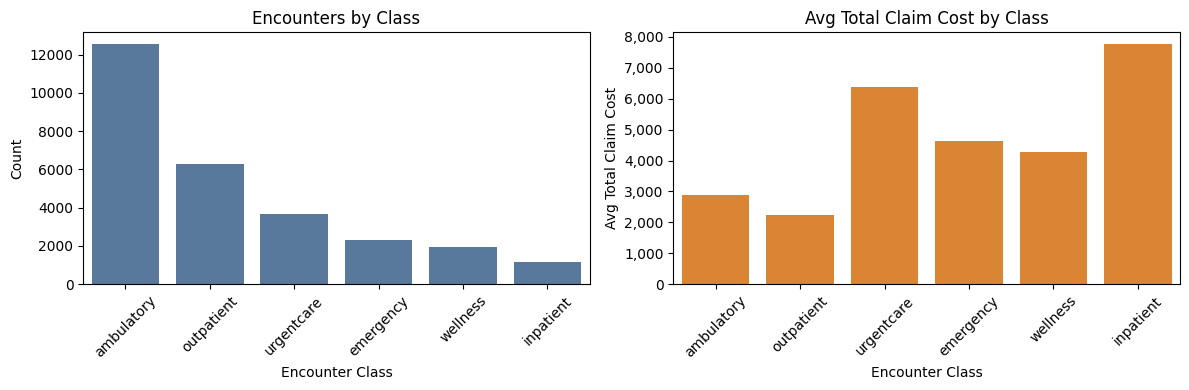

In [2]:
data_path = Path('/home/hadoop/homework/hive-vs-pig/data/encounters.csv')
if not data_path.exists():
    raise FileNotFoundError(f'Missing data file: {data_path}')

df = pd.read_csv(
    data_path,
    encoding='utf-8-sig',
    usecols=['ENCOUNTERCLASS', 'TOTAL_CLAIM_COST'],
)
df = df.dropna(subset=['ENCOUNTERCLASS'])
df['TOTAL_CLAIM_COST'] = pd.to_numeric(df['TOTAL_CLAIM_COST'], errors='coerce')

stats = (
    df.groupby('ENCOUNTERCLASS', as_index=False)
      .agg(count=('TOTAL_CLAIM_COST', 'size'), avg_cost=('TOTAL_CLAIM_COST', 'mean'))
      .sort_values('count', ascending=False)
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=stats, x='ENCOUNTERCLASS', y='count', ax=axes[0], color='#4C78A8')
axes[0].set_title('Encounters by Class')
axes[0].set_xlabel('Encounter Class')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=stats, x='ENCOUNTERCLASS', y='avg_cost', ax=axes[1], color='#F58518')
axes[1].set_title('Avg Total Claim Cost by Class')
axes[1].set_xlabel('Encounter Class')
axes[1].set_ylabel('Avg Total Claim Cost')
axes[1].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()


# Lab Hive vs Pig - Question 2 (Hive)

In [8]:
# Setup Hive tables using the Hive-adapted script
setup_path = '/home/hadoop/homework/hive-vs-pig/data/create_hospital_db_hive.sql'
subprocess.run(['hive', '-f', setup_path], env=env, check=True)

q21_sql = """
USE hospital_db;
SELECT
  pr.patient AS patient_id,
  concat(pa.first, ' ', pa.last) AS patient_name,
  pr.encounter AS encounter_id,
  pr.start_time,
  pr.stop_time,
  (unix_timestamp(regexp_replace(regexp_replace(pr.stop_time, 'T', ' '), 'Z', ''), 'yyyy-MM-dd HH:mm:ss') -
   unix_timestamp(regexp_replace(regexp_replace(pr.start_time, 'T', ' '), 'Z', ''), 'yyyy-MM-dd HH:mm:ss')) AS duration_sec
FROM procedures pr
LEFT JOIN patients pa ON pr.patient = pa.id
WHERE pr.start_time IS NOT NULL AND pr.stop_time IS NOT NULL
ORDER BY duration_sec DESC
LIMIT 5;
"""

run_hive(q21_sql)

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/home/hadoop/hive/lib/log4j-slf4j-impl-2.17.1.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/hadoop/hadoop/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Hive Session ID = ebeeb57c-48be-4f96-9107-72f3aa9f122b

Logging initialized using configuration in jar:file:/home/hadoop/hive/lib/hive-common-3.1.3.jar!/hive-log4j2.properties Async: true
Hive Session ID = 95be8e94-4c98-4406-beff-fa5303375bbc
OK
Time taken: 0.87 seconds
OK
Time taken: 0.079 seconds
OK
Time taken: 0.319 seconds
OK
Time taken: 0.763 seconds
OK
Time taken: 0.083 seconds
OK
Time taken: 0.082 seconds
OK
Time taken: 0.066 seconds
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding

2f6c035b-a11d-9373-89af-0cb2195592d2	Demetra94 Sawayn19	6fc6cbfc-ade5-c9ec-721c-4f71d9a1a815	2017-01-11T09:03:19Z	2017-01-27T09:03:19Z	1382400
0226f105-2572-1c6f-15f0-1aa0438e40d0	Phylis163 Block661	d5c42fa8-f110-b714-d89a-04ec57038a58	2013-10-22T02:32:09Z	2013-10-23T20:32:09Z	151200
41be6472-0a71-ef60-74f5-94601045eb15	Ike571 Becker968	cbb0d954-a4cf-425e-b2d4-b0b18378f9f2	2014-06-04T04:33:43Z	2014-06-05T19:33:43Z	140400
54889029-0a1e-0b75-5980-1c091dd4bc0e	Sharolyn456 Halvorson124	4079872d-73da-3b52-5306-2a978c6f5c8c	2018-07-19T02:25:40Z	2018-07-20T13:25:40Z	126000
a96d5031-46d5-e3f6-ec67-81f8edd48aa8	Spring819 Crooks415	0b29bad1-7b3c-2585-1b31-c3dd7a6ec36a	2017-09-30T15:52:26Z	2017-10-01T21:52:26Z	108000


Time taken: 34.546 seconds, Fetched: 5 row(s)


In [9]:
q22_sql = """
USE hospital_db;
SELECT
  pr.patient AS patient_id,
  concat(pa.first, ' ', pa.last) AS patient_name,
  pr.encounter AS encounter_id,
  pay.name AS payer_name,
  pr.base_cost AS procedure_cost
FROM procedures pr
JOIN encounters en ON pr.encounter = en.id
LEFT JOIN payers pay ON en.payer = pay.id
LEFT JOIN patients pa ON pr.patient = pa.id
ORDER BY procedure_cost DESC
LIMIT 5;
"""

run_hive(q22_sql)

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/home/hadoop/hive/lib/log4j-slf4j-impl-2.17.1.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/hadoop/hadoop/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Hive Session ID = e8b6b330-6f36-4f39-8cbf-56760aa9ccca

Logging initialized using configuration in jar:file:/home/hadoop/hive/lib/hive-common-3.1.3.jar!/hive-log4j2.properties Async: true
Hive Session ID = 59a5ec90-87c5-49af-a34b-17f9aa9db561
OK
Time taken: 0.748 seconds
No Stats for hospital_db@procedures, Columns: patient, base_cost, encounter
No Stats for hospital_db@encounters, Columns: id, payer
No Stats for hospital_db@payers, Columns: name, id
No Stats for hospital_db@patients, Columns: last, id, first
Qu

01296e88-f6d9-1c18-cf91-87523325e034	Tonisha838 Shields502	6c108963-2fda-815b-3813-a424b3533127	Anthem	289531.0
01296e88-f6d9-1c18-cf91-87523325e034	Tonisha838 Shields502	6c108963-2fda-815b-3813-a424b3533127	Anthem	236283.0
d9ec2e44-32e9-9148-179a-1653348cc4e2	Myrtis608 Lindgren255	7cd1c7e6-bd9e-b625-90f6-7ee85a69b2f8	Medicaid	199610.0
d9ec2e44-32e9-9148-179a-1653348cc4e2	Myrtis608 Lindgren255	7cd1c7e6-bd9e-b625-90f6-7ee85a69b2f8	Medicaid	193251.0
01296e88-f6d9-1c18-cf91-87523325e034	Tonisha838 Shields502	6c108963-2fda-815b-3813-a424b3533127	Anthem	112627.0


In [10]:
q23_sql = """
USE hospital_db;
SELECT
  pay.name AS payer_organization,
  en.payer_coverage,
  en.id AS encounter_id,
  en.total_claim_cost
FROM encounters en
LEFT JOIN payers pay ON en.payer = pay.id
WHERE substr(en.start_time, 1, 4) = '2022'
ORDER BY en.total_claim_cost DESC;
"""

run_hive(q23_sql)

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/home/hadoop/hive/lib/log4j-slf4j-impl-2.17.1.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/hadoop/hadoop/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Hive Session ID = eb8dcab8-022e-4874-9013-fb9bf687d32b

Logging initialized using configuration in jar:file:/home/hadoop/hive/lib/hive-common-3.1.3.jar!/hive-log4j2.properties Async: true
Hive Session ID = 3ca4e948-78af-4375-9c92-6d393fef0913
OK
Time taken: 0.722 seconds
Query ID = hadoop_20260109170108_8a004498-54de-4236-831f-fd59d84854fb
Total jobs = 1
2026-01-09 17:01:17	Dump the side-table for tag: 1 with group count: 10 into file: file:/home/hadoop/hive/tmp/eb8dcab8-022e-4874-9013-fb9bf687d32b/hive_2026-01-

NO_INSURANCE	0.0	03977ff3-f892-9de9-646a-f583380a0225	42833.78
NO_INSURANCE	0.0	2a672800-9702-f424-1f28-c00018a47a09	39370.33
NO_INSURANCE	0.0	f098e7f7-9270-c105-4d16-734a9bbe7ff5	33294.05
Medicare	22613.22	9d329ba9-4bd4-191b-e937-019a6f87b820	28364.38
NO_INSURANCE	0.0	04c343a0-8efe-294d-8aea-520b90d202fb	27749.94
Medicare	20588.26	3102b3e7-cfe9-5999-c2d4-f9e5bbf4e0d2	25910.13
NO_INSURANCE	0.0	02826839-6137-78de-4274-a80876cfd8c3	25514.03
Medicare	20235.27	cbc4aa02-ff77-81e6-e181-c49607258ad6	25399.37
Medicare	19708.54	00262cfb-5257-81ea-70e3-f176d9186ef5	24733.14
NO_INSURANCE	0.0	7da8f704-9bb3-27b6-67ab-a5089e1c35f5	24301.07
NO_INSURANCE	0.0	aa5670fa-e4df-8bef-dadb-bd593f92b104	22781.95
Medicare	17618.06	2d5570ae-1444-8298-207c-8a06851d6276	22062.57
NO_INSURANCE	0.0	be013ede-c6ad-fc16-6606-32ebdde119ae	19305.12
NO_INSURANCE	0.0	feb5e62c-3b59-4203-23ed-49758e5ccb53	19289.42
Blue Cross Blue Shield	14077.85	8fee1da3-2064-48d9-acdb-85a0869092c6	18845.46
Medicaid	16857.89	1da1bc81-f91a-f53

Time taken: 29.661 seconds, Fetched: 220 row(s)


# Lab Hive vs Pig - Question 2 (Pig)

In [4]:
# Q2.1
run_pig('/home/hadoop/homework/hive-vs-pig/pig_q2_1.pig')


2026-01-09 16:54:11,936 INFO pig.ExecTypeProvider: Trying ExecType : LOCAL
2026-01-09 16:54:11,937 INFO pig.ExecTypeProvider: Trying ExecType : MAPREDUCE
2026-01-09 16:54:11,938 INFO pig.ExecTypeProvider: Picked MAPREDUCE as the ExecType
2026-01-09 16:54:11,976 [main] INFO  org.apache.pig.Main - Apache Pig version 0.17.0 (r1797386) compiled Jun 02 2017, 15:41:58
2026-01-09 16:54:11,976 [main] INFO  org.apache.pig.Main - Logging error messages to: /home/hadoop/homework/pig_1767977651971.log
2026-01-09 16:54:12,213 [main] INFO  org.apache.pig.impl.util.Utils - Default bootup file /home/hadoop/.pigbootup not found
2026-01-09 16:54:12,278 [main] INFO  org.apache.hadoop.conf.Configuration.deprecation - mapred.job.tracker is deprecated. Instead, use mapreduce.jobtracker.address
2026-01-09 16:54:12,278 [main] INFO  org.apache.pig.backend.hadoop.executionengine.HExecutionEngine - Connecting to hadoop file system at: hdfs://server1:9000
2026-01-09 16:54:12,762 [main] INFO  org.apache.pig.PigSer

(2f6c035b-a11d-9373-89af-0cb2195592d2,Demetra94,Sawayn19,6fc6cbfc-ade5-c9ec-721c-4f71d9a1a815,2017-01-11 09:03:19,2017-01-27 09:03:19,1382400)
(0226f105-2572-1c6f-15f0-1aa0438e40d0,Phylis163,Block661,d5c42fa8-f110-b714-d89a-04ec57038a58,2013-10-22 02:32:09,2013-10-23 20:32:09,151200)
(41be6472-0a71-ef60-74f5-94601045eb15,Ike571,Becker968,cbb0d954-a4cf-425e-b2d4-b0b18378f9f2,2014-06-04 04:33:43,2014-06-05 19:33:43,140400)
(54889029-0a1e-0b75-5980-1c091dd4bc0e,Sharolyn456,Halvorson124,4079872d-73da-3b52-5306-2a978c6f5c8c,2018-07-19 02:25:40,2018-07-20 13:25:40,126000)
(a96d5031-46d5-e3f6-ec67-81f8edd48aa8,Spring819,Crooks415,0b29bad1-7b3c-2585-1b31-c3dd7a6ec36a,2017-09-30 15:52:26,2017-10-01 21:52:26,108000)


In [5]:
# Q2.2
run_pig('/home/hadoop/homework/hive-vs-pig/pig_q2_2.pig')


2026-01-09 16:55:51,578 INFO pig.ExecTypeProvider: Trying ExecType : LOCAL
2026-01-09 16:55:51,579 INFO pig.ExecTypeProvider: Trying ExecType : MAPREDUCE
2026-01-09 16:55:51,580 INFO pig.ExecTypeProvider: Picked MAPREDUCE as the ExecType
2026-01-09 16:55:51,619 [main] INFO  org.apache.pig.Main - Apache Pig version 0.17.0 (r1797386) compiled Jun 02 2017, 15:41:58
2026-01-09 16:55:51,619 [main] INFO  org.apache.pig.Main - Logging error messages to: /home/hadoop/homework/pig_1767977751614.log
2026-01-09 16:55:51,844 [main] INFO  org.apache.pig.impl.util.Utils - Default bootup file /home/hadoop/.pigbootup not found
2026-01-09 16:55:51,907 [main] INFO  org.apache.hadoop.conf.Configuration.deprecation - mapred.job.tracker is deprecated. Instead, use mapreduce.jobtracker.address
2026-01-09 16:55:51,907 [main] INFO  org.apache.pig.backend.hadoop.executionengine.HExecutionEngine - Connecting to hadoop file system at: hdfs://server1:9000
2026-01-09 16:55:52,348 [main] INFO  org.apache.pig.PigSer

(289531.0,01296e88-f6d9-1c18-cf91-87523325e034,Tonisha838,Shields502,Anthem,6c108963-2fda-815b-3813-a424b3533127)
(236283.0,01296e88-f6d9-1c18-cf91-87523325e034,Tonisha838,Shields502,Anthem,6c108963-2fda-815b-3813-a424b3533127)
(199610.0,d9ec2e44-32e9-9148-179a-1653348cc4e2,Myrtis608,Lindgren255,Medicaid,7cd1c7e6-bd9e-b625-90f6-7ee85a69b2f8)
(193251.0,d9ec2e44-32e9-9148-179a-1653348cc4e2,Myrtis608,Lindgren255,Medicaid,7cd1c7e6-bd9e-b625-90f6-7ee85a69b2f8)
(112627.0,01296e88-f6d9-1c18-cf91-87523325e034,Tonisha838,Shields502,Anthem,6c108963-2fda-815b-3813-a424b3533127)


In [6]:
# Q2.3
run_pig('/home/hadoop/homework/hive-vs-pig/pig_q2_3.pig')


2026-01-09 16:58:17,023 INFO pig.ExecTypeProvider: Trying ExecType : LOCAL
2026-01-09 16:58:17,024 INFO pig.ExecTypeProvider: Trying ExecType : MAPREDUCE
2026-01-09 16:58:17,024 INFO pig.ExecTypeProvider: Picked MAPREDUCE as the ExecType
2026-01-09 16:58:17,064 [main] INFO  org.apache.pig.Main - Apache Pig version 0.17.0 (r1797386) compiled Jun 02 2017, 15:41:58
2026-01-09 16:58:17,064 [main] INFO  org.apache.pig.Main - Logging error messages to: /home/hadoop/homework/pig_1767977897059.log
2026-01-09 16:58:17,295 [main] INFO  org.apache.pig.impl.util.Utils - Default bootup file /home/hadoop/.pigbootup not found
2026-01-09 16:58:17,354 [main] INFO  org.apache.hadoop.conf.Configuration.deprecation - mapred.job.tracker is deprecated. Instead, use mapreduce.jobtracker.address
2026-01-09 16:58:17,354 [main] INFO  org.apache.pig.backend.hadoop.executionengine.HExecutionEngine - Connecting to hadoop file system at: hdfs://server1:9000
2026-01-09 16:58:17,786 [main] INFO  org.apache.pig.PigSer

(NO_INSURANCE,0.0,03977ff3-f892-9de9-646a-f583380a0225,42833.78)
(NO_INSURANCE,0.0,2a672800-9702-f424-1f28-c00018a47a09,39370.33)
(NO_INSURANCE,0.0,f098e7f7-9270-c105-4d16-734a9bbe7ff5,33294.05)
(Medicare,22613.22,9d329ba9-4bd4-191b-e937-019a6f87b820,28364.38)
(NO_INSURANCE,0.0,04c343a0-8efe-294d-8aea-520b90d202fb,27749.94)
(Medicare,20588.26,3102b3e7-cfe9-5999-c2d4-f9e5bbf4e0d2,25910.13)
(NO_INSURANCE,0.0,02826839-6137-78de-4274-a80876cfd8c3,25514.03)
(Medicare,20235.27,cbc4aa02-ff77-81e6-e181-c49607258ad6,25399.37)
(Medicare,19708.54,00262cfb-5257-81ea-70e3-f176d9186ef5,24733.14)
(NO_INSURANCE,0.0,7da8f704-9bb3-27b6-67ab-a5089e1c35f5,24301.07)
(NO_INSURANCE,0.0,aa5670fa-e4df-8bef-dadb-bd593f92b104,22781.95)
(Medicare,17618.06,2d5570ae-1444-8298-207c-8a06851d6276,22062.57)
(NO_INSURANCE,0.0,be013ede-c6ad-fc16-6606-32ebdde119ae,19305.12)
(NO_INSURANCE,0.0,feb5e62c-3b59-4203-23ed-49758e5ccb53,19289.42)
(Blue Cross Blue Shield,14077.85,8fee1da3-2064-48d9-acdb-85a0869092c6,18845.46)
(Medi